In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split


import warnings
warnings.simplefilter('ignore')

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_selection import RFECV

In [3]:
tourney_result = pd.read_csv('../input/kaggle_data/MNCAATourneyCompactResults.csv')

tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'],axis=1)

In [4]:
coty = pd.read_csv('../input/coty.csv')
adj_eff = pd.read_csv('../input/self_calculated/adjusted_efficiencies.csv')
consistency = pd.read_csv('../input/self_calculated/consistency.csv')
maj_conf = pd.read_csv('../input/major_conferences.csv')

In [5]:
ordinals = pd.read_csv('../input/kaggle_data/MMasseyOrdinals.csv')

ordinals_df = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()

POM_ordinals = ordinals_df[ordinals_df['SystemName']=='POM']
MOR_ordinals = ordinals_df[ordinals_df['SystemName']=='MOR']
DOK_ordinals = ordinals_df[ordinals_df['SystemName']=='DOK']
SAG_ordinals = ordinals_df[ordinals_df['SystemName']=='SAG']
LMC_ordinals = ordinals_df[ordinals_df['SystemName']=='LMC']

ordinals_df.SystemName.value_counts()

MOR    6177
RTH    6177
SAG    6177
WOL    6177
POM    6174
WLK    6174
DOL    6173
COL    6171
CNG    5847
SEL    5831
BIH    5830
WOB    5824
DUN    5521
RPI    5473
DOK    5194
WIL    5190
PIG    5187
MAS    4819
BOB    4778
STH    4524
REW    4524
PGH    4517
KRA    4507
DC     4472
SPW    4180
LMC    4179
DCI    4176
KPK    4170
RT     3836
SE     3771
       ... 
JRT     351
INP     347
KEL     347
TOL     347
PEQ     345
BP5     345
AUS     345
HAT     345
BNM     345
UPS     345
BNZ     344
TBD     344
RWP     344
DP      344
KCX     344
TS      344
RSE     341
BKM     341
CMV     330
WTE     327
BRZ     327
ERD     327
JON     326
MGY     326
PH      326
RM      326
NOR     326
GC      325
MIC     324
TRX     175
Name: SystemName, Length: 179, dtype: int64

In [6]:
tm_to_pct = pd.read_csv('../input/self_calculated/tm_to_pct.csv')

opp_to_pct = pd.read_csv('../input/self_calculated/opp_to_pct.csv')

tm_orb_pct = pd.read_csv('../input/self_calculated/tm_orb_pct.csv')

tm_drb_pct = pd.read_csv('../input/self_calculated/tm_drb_pct.csv')

tm_efg_pct = pd.read_csv('../input/self_calculated/tm_efg_pct.csv')

opp_efg_pct = pd.read_csv('../input/self_calculated/opp_efg_pct.csv')

tm_fta_rate = pd.read_csv('../input/self_calculated/tm_fta_rate.csv')

opp_fta_rate = pd.read_csv('../input/self_calculated/opp_fta_rate.csv')

tm_ft_pct = pd.read_csv('../input/self_calculated/tm_ft_pct.csv')

shoot_const = pd.read_csv('../input/self_calculated/shooting_consistency.csv')

tempo = pd.read_csv('../input/self_calculated/tempo.csv')

In [7]:
all_teams = adj_eff.merge(coty,on=['Season','TeamID'])
all_teams = all_teams.merge(consistency,on=['Season','TeamID'])
all_teams = all_teams.merge(maj_conf,on=['Season','TeamID'])
all_teams = all_teams.merge(tempo,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tempo'},inplace=True)

all_teams = all_teams.merge(tm_to_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tm_to_pct'},inplace=True)

all_teams = all_teams.merge(opp_to_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'opp_to_pct'},inplace=True)

all_teams = all_teams.merge(tm_efg_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tm_efg_pct'},inplace=True)

all_teams = all_teams.merge(opp_efg_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'opp_efg_pct'},inplace=True)

all_teams = all_teams.merge(tm_orb_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tm_orb_pct'},inplace=True)

all_teams = all_teams.merge(tm_drb_pct,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tm_drb_pct'},inplace=True)

all_teams = all_teams.merge(tm_fta_rate,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'tm_fta_rate'},inplace=True)

all_teams = all_teams.merge(opp_fta_rate,on=['Season','TeamID'])
all_teams.rename(columns={'adj_stat':'opp_fta_rate'},inplace=True)

all_teams = all_teams.merge(tm_ft_pct,on=['Season','TeamID'])

all_teams = all_teams.merge(shoot_const,on=['Season','TeamID'])

all_teams = all_teams.drop(['RawNetEff','raw_stat_x','raw_stat_y','raw_stat','ConfAbbrev'],axis=1)
all_teams.rename(columns={'tm_off_eff_std':'off_cons','tm_def_eff_std':'def_cons'},inplace=True)
# all_teams = all_teams[['Season','TeamID','AdjNetEff','coty','tm_off_eff_std','tm_def_eff_std','MajorConf','tm_to_pct','opp_to_pct','tm_efg_pct','opp_efg_pct','tm_orb_pct','tm_drb_pct','tm_fta_rate','opp_fta_rate','tm_ft_pct']]
# 

# all_teams.columns = ['Season','TeamID','AdjNetEff','coty','Pos_std','off_cons','def_cons','MajorConf','tempo','tm_to_pct','opp_to_pct','tm_efg_pct','opp_efg_pct','tm_orb_pct','tm_drb_pct','tm_fta_rate','opp_fta_rate','tm_ft_pct', 'tm_ts_std', 'opp_ts_std', 'tm_efg_std', 'opp_efg_std']



all_teams.columns



Index(['Season', 'TeamID', 'AdjNetEff', 'coty', 'Pos_std', 'off_cons',
       'def_cons', 'MajorConf', 'tempo', 'tm_to_pct', 'opp_to_pct',
       'tm_efg_pct', 'opp_efg_pct', 'tm_orb_pct', 'tm_drb_pct', 'tm_fta_rate',
       'opp_fta_rate', 'tm_ft_pct', 'tm_ts_std', 'opp_ts_std', 'tm_efg_std',
       'opp_efg_std'],
      dtype='object')

In [8]:
all_teams = all_teams.merge(POM_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_POM'},inplace=True)
all_teams = all_teams.merge(MOR_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_MOR'},inplace=True)
all_teams = all_teams.merge(SAG_ordinals, on=['Season','TeamID'])
all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
all_teams.rename(columns={'OrdinalRank':'Rank_SAG'},inplace=True)
# all_teams = all_teams.merge(DOK_ordinals, on=['Season','TeamID'])
# all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
# all_teams.rename(columns={'OrdinalRank':'Rank_DOK'},inplace=True)
# all_teams = all_teams.merge(LMC_ordinals, on=['Season','TeamID'])
# all_teams = all_teams.drop(['RankingDayNum','SystemName'],axis=1)
# all_teams.rename(columns={'OrdinalRank':'Rank_LMC'},inplace=True)
all_teams.columns

Index(['Season', 'TeamID', 'AdjNetEff', 'coty', 'Pos_std', 'off_cons',
       'def_cons', 'MajorConf', 'tempo', 'tm_to_pct', 'opp_to_pct',
       'tm_efg_pct', 'opp_efg_pct', 'tm_orb_pct', 'tm_drb_pct', 'tm_fta_rate',
       'opp_fta_rate', 'tm_ft_pct', 'tm_ts_std', 'opp_ts_std', 'tm_efg_std',
       'opp_efg_std', 'Rank_POM', 'Rank_MOR', 'Rank_SAG'],
      dtype='object')

In [9]:
df1 = tourney_result
df2 = all_teams

df = df1.merge(df2,left_on=['Season','WTeamID'],right_on=['Season','TeamID'], how="inner")

df = df.drop(['TeamID'],axis=1)



df = df.merge(df2,left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='inner')
df = df.drop(['TeamID'],axis=1)

print(df.columns)

Index(['Season', 'WTeamID', 'LTeamID', 'AdjNetEff_x', 'coty_x', 'Pos_std_x',
       'off_cons_x', 'def_cons_x', 'MajorConf_x', 'tempo_x', 'tm_to_pct_x',
       'opp_to_pct_x', 'tm_efg_pct_x', 'opp_efg_pct_x', 'tm_orb_pct_x',
       'tm_drb_pct_x', 'tm_fta_rate_x', 'opp_fta_rate_x', 'tm_ft_pct_x',
       'tm_ts_std_x', 'opp_ts_std_x', 'tm_efg_std_x', 'opp_efg_std_x',
       'Rank_POM_x', 'Rank_MOR_x', 'Rank_SAG_x', 'AdjNetEff_y', 'coty_y',
       'Pos_std_y', 'off_cons_y', 'def_cons_y', 'MajorConf_y', 'tempo_y',
       'tm_to_pct_y', 'opp_to_pct_y', 'tm_efg_pct_y', 'opp_efg_pct_y',
       'tm_orb_pct_y', 'tm_drb_pct_y', 'tm_fta_rate_y', 'opp_fta_rate_y',
       'tm_ft_pct_y', 'tm_ts_std_y', 'opp_ts_std_y', 'tm_efg_std_y',
       'opp_efg_std_y', 'Rank_POM_y', 'Rank_MOR_y', 'Rank_SAG_y'],
      dtype='object')


In [10]:
df_win = df.copy()

df_lose = df_win.copy()

df_lose['AdjNetEff_x'] = df_win['AdjNetEff_y']
df_lose['AdjNetEff_y'] = df_win['AdjNetEff_x']

df_lose['coty_x'] = df_win['coty_y']
df_lose['coty_y'] = df_win['coty_x']

df_lose['Pos_std_x'] = df_win['Pos_std_y']
df_lose['Pos_std_y'] = df_win['Pos_std_x']

df_lose['off_cons_x'] = df_win['off_cons_y']
df_lose['off_cons_y'] = df_win['off_cons_x']

df_lose['def_cons_x'] = df_win['def_cons_y']
df_lose['def_cons_y'] = df_win['def_cons_x']

df_lose['Rank_POM_x'] = df_win['Rank_POM_y']
df_lose['Rank_POM_y'] = df_win['Rank_POM_x']

df_lose['Rank_MOR_x'] = df_win['Rank_MOR_y']
df_lose['Rank_MOR_y'] = df_win['Rank_MOR_x']

df_lose['Rank_SAG_x'] = df_win['Rank_SAG_y']
df_lose['Rank_SAG_y'] = df_win['Rank_SAG_x']

df_lose['MajorConf_x'] = df_win['MajorConf_y']
df_lose['MajorConf_y'] = df_win['MajorConf_x']

df_lose['tempo_x'] = df_win['tempo_y']
df_lose['tempo_y'] = df_win['tempo_x']

df_lose['tm_to_pct_x'] = df_win['tm_to_pct_y']
df_lose['tm_to_pct_y'] = df_win['tm_to_pct_x']

df_lose['tm_efg_pct_x'] = df_win['tm_efg_pct_y']
df_lose['tm_efg_pct_y'] = df_win['tm_efg_pct_x']

df_lose['tm_orb_pct_x'] = df_win['tm_orb_pct_y']
df_lose['tm_orb_pct_y'] = df_win['tm_orb_pct_x']

df_lose['tm_fta_rate_x'] = df_win['tm_fta_rate_y']
df_lose['tm_fta_rate_y'] = df_win['tm_fta_rate_x']

df_lose['opp_to_pct_x'] = df_win['opp_to_pct_y']
df_lose['opp_to_pct_y'] = df_win['opp_to_pct_x']

df_lose['opp_efg_pct_x'] = df_win['opp_efg_pct_y']
df_lose['opp_efg_pct_y'] = df_win['opp_efg_pct_x']

df_lose['tm_drb_pct_x'] = df_win['tm_drb_pct_y']
df_lose['tm_drb_pct_y'] = df_win['tm_drb_pct_x']

df_lose['opp_fta_rate_x'] = df_win['opp_fta_rate_y']
df_lose['opp_fta_rate_y'] = df_win['opp_fta_rate_x']

df_lose['tm_ft_pct_x'] = df_win['tm_ft_pct_y']
df_lose['tm_ft_pct_y'] = df_win['tm_ft_pct_x']

df_lose['tm_ts_std_x'] = df_win['tm_ts_std_y']
df_lose['tm_ts_std_y'] = df_win['tm_ts_std_x']

df_lose['tm_efg_std_x'] = df_win['tm_efg_std_y']
df_lose['tm_efg_std_y'] = df_win['tm_efg_std_x']

df_lose['opp_ts_std_x'] = df_win['opp_ts_std_y']
df_lose['opp_ts_std_y'] = df_win['opp_ts_std_x']

df_lose['opp_efg_std_x'] = df_win['opp_efg_std_y']
df_lose['opp_efg_std_y'] = df_win['opp_efg_std_x']

# df_lose['Rank_LMC_x'] = df_win['Rank_LMC_y']
# df_lose['Rank_LMC_y'] = df_win['Rank_LMC_x']

# df_lose['Rank_DOK_x'] = df_win['Rank_DOK_y']
# df_lose['Rank_DOK_y'] = df_win['Rank_DOK_x']

df_lose

,Season,WTeamID,LTeamID,AdjNetEff_x,coty_x,Pos_std_x,off_cons_x,def_cons_x,MajorConf_x,tempo_x,...,tm_fta_rate_y,opp_fta_rate_y,tm_ft_pct_y,tm_ts_std_y,opp_ts_std_y,tm_efg_std_y,opp_efg_std_y,Rank_POM_y,Rank_MOR_y,Rank_SAG_y
0,2003,1421,1411,-8.798933,0,5.398157,14.155399,18.094586,0,66.068974,...,0.362902,0.376445,0.762768,0.078511,0.066395,0.083454,0.078172,273,277,251
1,2003,1112,1436,2.581903,0,6.355992,17.182535,13.232777,0,63.270972,...,0.397280,0.292509,0.701429,0.065754,0.053110,0.065593,0.055759,3,4,2
2,2003,1112,1211,16.074004,0,5.594072,13.140022,16.089789,0,66.356687,...,0.397280,0.292509,0.701429,0.065754,0.053110,0.065593,0.055759,3,4,2
3,2003,1112,1323,21.393782,0,7.076271,13.962640,19.286616,1,68.509109,...,0.397280,0.292509,0.701429,0.065754,0.053110,0.065593,0.055759,3,4,2
4,2003,1113,1272,17.376061,0,5.423252,9.061950,14.344667,0,66.727488,...,0.473241,0.376967,0.669737,0.083592,0.084055,0.089700,0.086035,32,22,32
5,2003,1141,1166,21.599672,0,4.867409,14.467639,15.065417,0,67.075465,...,0.469109,0.356625,0.765753,0.089770,0.071136,0.103201,0.072915,50,50,48
6,2003,1143,1301,13.249313,0,5.949877,15.369050,15.957973,1,63.735638,...,0.359461,0.311497,0.685512,0.064972,0.074371,0.061246,0.073897,40,43,40
7,2003,1163,1140,19.820683,0,4.793785,14.503437,15.874542,0,63.861011,...,0.363548,0.342219,0.674208,0.069197,0.071191,0.081372,0.072596,23,17,23
8,2003,1163,1390,15.205756,0,4.488166,11.922719,12.970978,0,63.762434,...,0.363548,0.342219,0.674208,0.069197,0.071191,0.081372,0.072596,23,17,23
9,2003,1181,1161,5.709327,0,6.421431,13.839161,15.873602,0,65.646667,...,0.486971,0.389676,0.709026,0.072773,0.073881,0.081948,0.073525,8,10,10


In [11]:
df_win['result'] = 1
df_lose['result'] = 0

df_final = pd.concat((df_win,df_lose)).reset_index(drop=True)

df_final['AdjNetEff_Diff'] = df_final['AdjNetEff_x'] - df_final['AdjNetEff_y']
# df_final['Rank_POM_Diff'] = df_final['Rank_POM_x'] = df_final['Rank_POM_y']
# df_final['Rank_MOR_Diff'] = df_final['Rank_MOR_x'] = df_final['Rank_MOR_y']
# df_final['Rank_SAG_Diff'] = df_final['Rank_SAG_x'] = df_final['Rank_SAG_y']
# df_final['Rank_DOK_Diff'] = df_final['Rank_DOK_x'] = df_final['Rank_DOK_y']
# df_final['Rank_LMC_Diff'] = df_final['Rank_LMC_x'] = df_final['Rank_LMC_y']

df_final = df_final[df_final['Season']<2015]

df_final = df_final.drop(['Season','WTeamID','LTeamID','AdjNetEff_x','AdjNetEff_y'],axis=1)

#df_final = df_final.drop(['Season','WTeamID','LTeamID'],axis=1)

print(df_final.columns)

df_final

Index(['coty_x', 'Pos_std_x', 'off_cons_x', 'def_cons_x', 'MajorConf_x',
       'tempo_x', 'tm_to_pct_x', 'opp_to_pct_x', 'tm_efg_pct_x',
       'opp_efg_pct_x', 'tm_orb_pct_x', 'tm_drb_pct_x', 'tm_fta_rate_x',
       'opp_fta_rate_x', 'tm_ft_pct_x', 'tm_ts_std_x', 'opp_ts_std_x',
       'tm_efg_std_x', 'opp_efg_std_x', 'Rank_POM_x', 'Rank_MOR_x',
       'Rank_SAG_x', 'coty_y', 'Pos_std_y', 'off_cons_y', 'def_cons_y',
       'MajorConf_y', 'tempo_y', 'tm_to_pct_y', 'opp_to_pct_y', 'tm_efg_pct_y',
       'opp_efg_pct_y', 'tm_orb_pct_y', 'tm_drb_pct_y', 'tm_fta_rate_y',
       'opp_fta_rate_y', 'tm_ft_pct_y', 'tm_ts_std_y', 'opp_ts_std_y',
       'tm_efg_std_y', 'opp_efg_std_y', 'Rank_POM_y', 'Rank_MOR_y',
       'Rank_SAG_y', 'result', 'AdjNetEff_Diff'],
      dtype='object')


,coty_x,Pos_std_x,off_cons_x,def_cons_x,MajorConf_x,tempo_x,tm_to_pct_x,opp_to_pct_x,tm_efg_pct_x,opp_efg_pct_x,...,tm_ft_pct_y,tm_ts_std_y,opp_ts_std_y,tm_efg_std_y,opp_efg_std_y,Rank_POM_y,Rank_MOR_y,Rank_SAG_y,result,AdjNetEff_Diff
0,0,6.231404,16.642408,14.289006,0,67.168688,17.326257,11.891931,0.479754,0.532603,...,0.619952,0.074385,0.092776,0.074366,0.104063,268,293,257,1,-6.491479
1,0,5.680541,13.211491,13.021743,0,71.821501,13.258635,16.974193,0.530209,0.442962,...,0.657848,0.082384,0.061089,0.086233,0.064465,144,187,158,1,25.295647
2,0,5.680541,13.211491,13.021743,0,71.821501,13.258635,16.974193,0.530209,0.442962,...,0.721204,0.076740,0.065442,0.080918,0.067441,41,54,39,1,11.803546
3,0,5.680541,13.211491,13.021743,0,71.821501,13.258635,16.974193,0.530209,0.442962,...,0.759887,0.072573,0.090167,0.075609,0.101280,22,36,17,1,6.483768
4,0,4.578849,16.289954,17.096088,0,65.028697,14.105987,17.462729,0.534947,0.486342,...,0.653614,0.067897,0.076312,0.081319,0.073661,20,23,24,1,1.013994
5,0,4.516705,16.061633,12.116463,0,68.917530,18.665371,16.967011,0.565467,0.493446,...,0.692890,0.070126,0.066268,0.084338,0.078678,27,33,18,1,-11.255168
6,0,5.308415,10.462607,15.701468,0,65.698776,14.223611,16.591197,0.529460,0.489442,...,0.770358,0.081099,0.075786,0.086203,0.073279,48,31,46,1,0.215371
7,1,6.003303,15.141179,12.875165,1,69.287969,14.727512,14.328170,0.532739,0.423644,...,0.753004,0.071187,0.078240,0.076299,0.074098,26,42,28,1,-1.433052
8,1,6.003303,15.141179,12.875165,1,69.287969,14.727512,14.328170,0.532739,0.423644,...,0.675466,0.082858,0.074001,0.092047,0.081061,30,25,29,1,3.181876
9,0,6.584967,11.334966,16.073131,1,69.594510,14.037699,18.646525,0.538401,0.468795,...,0.700549,0.061907,0.092330,0.073425,0.092694,87,85,89,1,17.349056


In [12]:
pt = PowerTransformer()
pt.fit(np.array(df_final['Rank_POM_x']).reshape(-1,1))
df_final['Rank_POM_x_v2'] = pt.transform(np.array(df_final['Rank_POM_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_POM_y']).reshape(-1,1))
df_final['Rank_POM_y_v2'] = pt.transform(np.array(df_final['Rank_POM_y']).reshape(-1,1))

pt.fit(np.array(df_final['Rank_MOR_x']).reshape(-1,1))
df_final['Rank_MOR_x_v2'] = pt.transform(np.array(df_final['Rank_MOR_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_MOR_y']).reshape(-1,1))
df_final['Rank_MOR_y_v2'] = pt.transform(np.array(df_final['Rank_MOR_y']).reshape(-1,1))

pt.fit(np.array(df_final['Rank_SAG_x']).reshape(-1,1))
df_final['Rank_SAG_x_v2'] = pt.transform(np.array(df_final['Rank_SAG_x']).reshape(-1,1))
pt.fit(np.array(df_final['Rank_SAG_y']).reshape(-1,1))
df_final['Rank_SAG_y_v2'] = pt.transform(np.array(df_final['Rank_SAG_y']).reshape(-1,1))

# pt.fit(np.array(df_final['Rank_LMC_x']).reshape(-1,1))
# df_final['Rank_LMC_x_v2'] = pt.transform(np.array(df_final['Rank_LMC_x']).reshape(-1,1))
# pt.fit(np.array(df_final['Rank_LMC_y']).reshape(-1,1))
# df_final['Rank_LMC_y_v2'] = pt.transform(np.array(df_final['Rank_LMC_y']).reshape(-1,1))

# pt.fit(np.array(df_final['Rank_DOK_x']).reshape(-1,1))
# df_final['Rank_DOK_x_v2'] = pt.transform(np.array(df_final['Rank_DOK_x']).reshape(-1,1))
# pt.fit(np.array(df_final['Rank_DOK_y']).reshape(-1,1))
# df_final['Rank_DOK_y_v2'] = pt.transform(np.array(df_final['Rank_DOK_y']).reshape(-1,1))

df_final = df_final.drop(['Rank_POM_x','Rank_POM_y'],axis=1)
df_final = df_final.drop(['Rank_MOR_x','Rank_MOR_y'],axis=1)
df_final = df_final.drop(['Rank_SAG_x','Rank_SAG_y'],axis=1)
# df_final = df_final.drop(['Rank_LMC_x','Rank_LMC_y'],axis=1)
# df_final = df_final.drop(['Rank_DOK_x','Rank_DOK_y'],axis=1)

df_final['Rank_POM_v2_Diff'] = df_final['Rank_POM_x_v2'] = df_final['Rank_POM_y_v2']
df_final['Rank_MOR_v2_Diff'] = df_final['Rank_MOR_x_v2'] = df_final['Rank_MOR_y_v2']
df_final['Rank_SAG_v2_Diff'] = df_final['Rank_SAG_x_v2'] = df_final['Rank_SAG_y_v2']
# df_final['Rank_LMC_v2_Diff'] = df_final['Rank_LMC_x_v2'] = df_final['Rank_LMC_y_v2']
# df_final['Rank_DOK_v2_Diff'] = df_final['Rank_DOK_x_v2'] = df_final['Rank_DOK_y_v2']

df_final = df_final.drop(['Rank_POM_x_v2','Rank_POM_y_v2'],axis=1)
df_final = df_final.drop(['Rank_MOR_x_v2','Rank_MOR_y_v2'],axis=1)
df_final = df_final.drop(['Rank_SAG_x_v2','Rank_SAG_y_v2'],axis=1)
# df_final = df_final.drop(['Rank_LMC_x_v2','Rank_LMC_y_v2'],axis=1)
# df_final = df_final.drop(['Rank_DOK_x_v2','Rank_DOK_y_v2'],axis=1)

In [13]:
# df_final[['AdjNetEff_Diff','Rank_POM_v2_Diff','Rank_MOR_v2_Diff','Rank_SAG_v2_Diff']].corr()

In [40]:
df_final.columns

Index(['coty_x', 'Pos_std_x', 'off_cons_x', 'def_cons_x', 'MajorConf_x',
       'tempo_x', 'tm_to_pct_x', 'opp_to_pct_x', 'tm_efg_pct_x',
       'opp_efg_pct_x', 'tm_orb_pct_x', 'tm_drb_pct_x', 'tm_fta_rate_x',
       'opp_fta_rate_x', 'tm_ft_pct_x', 'tm_ts_std_x', 'opp_ts_std_x',
       'tm_efg_std_x', 'opp_efg_std_x', 'coty_y', 'Pos_std_y', 'off_cons_y',
       'def_cons_y', 'MajorConf_y', 'tempo_y', 'tm_to_pct_y', 'opp_to_pct_y',
       'tm_efg_pct_y', 'opp_efg_pct_y', 'tm_orb_pct_y', 'tm_drb_pct_y',
       'tm_fta_rate_y', 'opp_fta_rate_y', 'tm_ft_pct_y', 'tm_ts_std_y',
       'opp_ts_std_y', 'tm_efg_std_y', 'opp_efg_std_y', 'result',
       'AdjNetEff_Diff', 'Rank_POM_v2_Diff', 'Rank_MOR_v2_Diff',
       'Rank_SAG_v2_Diff'],
      dtype='object')

In [15]:
# print(df_final.columns)
# df_final = df_final[['Rank_POM_v2_Diff',
#        'Rank_MOR_v2_Diff', 'Rank_SAG_v2_Diff','result']]

In [16]:
X = df_final.drop('result',axis=1)
y = df_final.result
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [17]:
def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
def get_auc_scores(y_actual, method, method2):
    auc_score = roc_auc_score(y_actual, method)
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2)
    return (auc_score, fpr_df, tpr_df)

In [18]:
param_grid = {'C':np.logspace(start=-5,stop=3,num=9),
            'solver':['lbfgs','liblinear','sag','saga'],
            'max_iter':[50,100]
}
LogReg_Grid = GridSearchCV(LogisticRegression(),param_grid, cv=10, refit=True, verbose=0, scoring='neg_log_loss')
LogReg_Grid.fit(X_train, y_train)
best_model(LogReg_Grid)

-0.5420383134529846
{'C': 0.001, 'max_iter': 50, 'solver': 'lbfgs'}
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [19]:
param_grid ={'alpha':np.logspace(start=-5,stop=3,num=9),
             'max_iter':[100,500,1000],
             'loss':['log','modified_huber']
}
SGD_Grid = GridSearchCV(SGDClassifier(),param_grid, cv=10,refit=True, verbose=0, scoring='neg_log_loss')
SGD_Grid.fit(X_train,y_train)
best_model(SGD_Grid)

-0.5463905373550044
{'alpha': 1.0, 'loss': 'log', 'max_iter': 1000}
SGDClassifier(alpha=1.0, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [20]:
LR_model = LogReg_Grid.best_estimator_
SGD_model = SGD_Grid.best_estimator_

auc_LR, fpr_LR, tpr_LR = get_auc_scores(y_test, LR_model.predict(X_test),LR_model.predict_proba(X_test)[:,1])
auc_SGD, fpr_SGD, tpr_SGD = get_auc_scores(y_test, SGD_model.predict(X_test),SGD_model.predict_proba(X_test)[:,1])

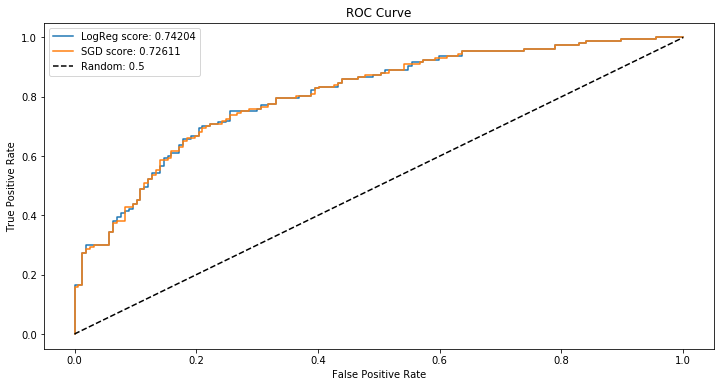

In [21]:
fig = plt.figure(figsize=(12,6), linewidth=1)
plt.plot(fpr_LR, tpr_LR, label='LogReg score: ' + str(round(auc_LR,5)))
plt.plot(fpr_SGD, tpr_SGD, label='SGD score: ' + str(round(auc_SGD,5)))
plt.plot([0,1],[0,1],'k--', label='Random: 0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

plt.show()

In [22]:
from sklearn.calibration import calibration_curve

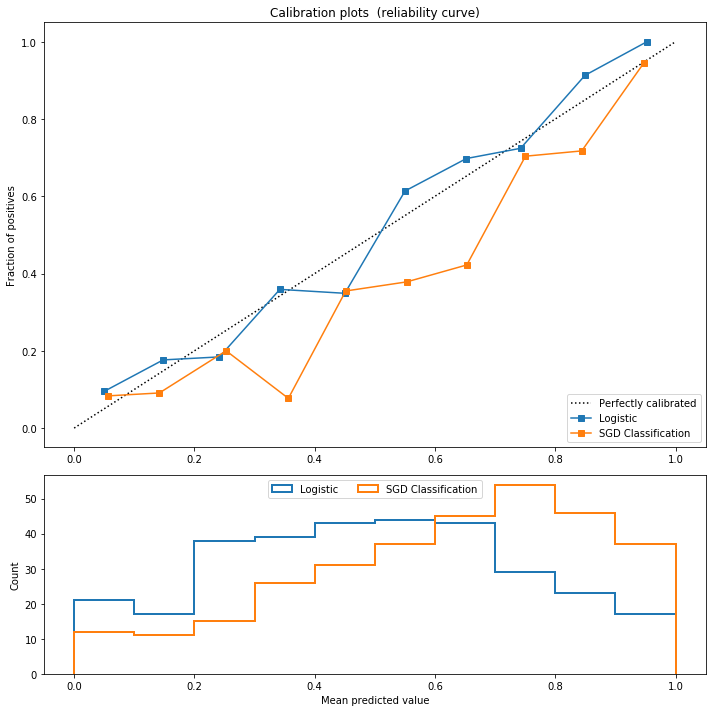

In [23]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(LR_model, 'Logistic'),
                  (SGD_model, 'SGD Classification')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

Otpimal number of features: 1


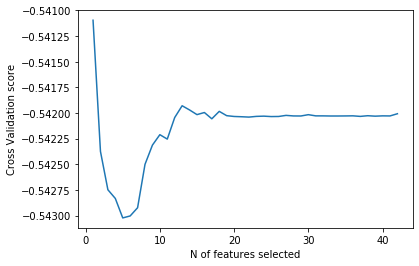

In [24]:
min_features_to_select = 1 
lr_clf = LR_model
rfecv = RFECV(estimator=lr_clf, step=1, cv=10, scoring='neg_log_loss', min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

print('Otpimal number of features: %d' % rfecv.n_features_)


plt.figure()
plt.xlabel('N of features selected')
plt.ylabel('Cross Validation score')
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [25]:
for i in range(X_train.shape[1]):
    print('Column %s, Selected %s, Rank %.3f' % (X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column coty_x, Selected False, Rank 17.000
Column Pos_std_x, Selected False, Rank 16.000
Column off_cons_x, Selected False, Rank 5.000
Column def_cons_x, Selected False, Rank 7.000
Column MajorConf_x, Selected False, Rank 18.000
Column tempo_x, Selected False, Rank 15.000
Column tm_to_pct_x, Selected False, Rank 6.000
Column opp_to_pct_x, Selected False, Rank 2.000
Column tm_efg_pct_x, Selected False, Rank 28.000
Column opp_efg_pct_x, Selected False, Rank 41.000
Column tm_orb_pct_x, Selected False, Rank 20.000
Column tm_drb_pct_x, Selected False, Rank 42.000
Column tm_fta_rate_x, Selected False, Rank 22.000
Column opp_fta_rate_x, Selected False, Rank 29.000
Column tm_ft_pct_x, Selected False, Rank 39.000
Column tm_ts_std_x, Selected False, Rank 34.000
Column opp_ts_std_x, Selected False, Rank 35.000
Column tm_efg_std_x, Selected False, Rank 36.000
Column opp_efg_std_x, Selected False, Rank 38.000
Column coty_y, Selected False, Rank 10.000
Column Pos_std_y, Selected False, Rank 3.000
Co

In [45]:
X = df_final[['AdjNetEff_Diff','off_cons_x','off_cons_y','def_cons_x','def_cons_y',
              'tm_to_pct_x','tm_to_pct_y','opp_to_pct_x','opp_to_pct_y','Pos_std_x','Pos_std_y','tm_ts_std_x', 'opp_ts_std_x',
       'tm_efg_std_x', 'opp_efg_std_x','tm_ts_std_y',
       'opp_ts_std_y', 'tm_efg_std_y', 'opp_efg_std_y','tempo_x','tempo_y']]
y = df_final.result
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)

In [46]:
param_grid = {'C':np.logspace(start=-5,stop=3,num=9),
            'solver':['lbfgs','liblinear','sag','saga'],
            'max_iter':[50,100]
}
LogReg_Grid = GridSearchCV(LogisticRegression(),param_grid, cv=10, refit=True, verbose=0, scoring='neg_log_loss')
LogReg_Grid.fit(X_train, y_train)
best_model(LogReg_Grid)

-0.5419399511908751
{'C': 0.001, 'max_iter': 100, 'solver': 'sag'}
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)


Otpimal number of features: 1


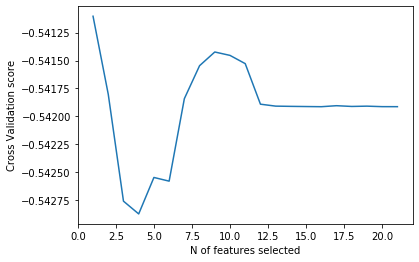

In [47]:
min_features_to_select = 1 
lr_clf = LogReg_Grid.best_estimator_
rfecv = RFECV(estimator=lr_clf, step=1, cv=10, scoring='neg_log_loss', min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

print('Otpimal number of features: %d' % rfecv.n_features_)


plt.figure()
plt.xlabel('N of features selected')
plt.ylabel('Cross Validation score')
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [48]:
for i in range(X_train.shape[1]):
    print('Column %s, Selected %s, Rank %.3f' % (X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))

Column AdjNetEff_Diff, Selected True, Rank 1.000
Column off_cons_x, Selected False, Rank 3.000
Column off_cons_y, Selected False, Rank 9.000
Column def_cons_x, Selected False, Rank 7.000
Column def_cons_y, Selected False, Rank 6.000
Column tm_to_pct_x, Selected False, Rank 5.000
Column tm_to_pct_y, Selected False, Rank 10.000
Column opp_to_pct_x, Selected False, Rank 4.000
Column opp_to_pct_y, Selected False, Rank 8.000
Column Pos_std_x, Selected False, Rank 12.000
Column Pos_std_y, Selected False, Rank 2.000
Column tm_ts_std_x, Selected False, Rank 16.000
Column opp_ts_std_x, Selected False, Rank 17.000
Column tm_efg_std_x, Selected False, Rank 18.000
Column opp_efg_std_x, Selected False, Rank 20.000
Column tm_ts_std_y, Selected False, Rank 14.000
Column opp_ts_std_y, Selected False, Rank 15.000
Column tm_efg_std_y, Selected False, Rank 19.000
Column opp_efg_std_y, Selected False, Rank 13.000
Column tempo_x, Selected False, Rank 11.000
Column tempo_y, Selected False, Rank 21.000


In [49]:
test_df = pd.read_csv('../input/kaggle_data/MSampleSubmissionStage1.csv')

In [50]:
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df

,ID,Pred,Season,WTeamID,LTeamID
0,2015_1107_1112,0.5,2015,1107,1112
1,2015_1107_1116,0.5,2015,1107,1116
2,2015_1107_1124,0.5,2015,1107,1124
3,2015_1107_1125,0.5,2015,1107,1125
4,2015_1107_1129,0.5,2015,1107,1129
5,2015_1107_1138,0.5,2015,1107,1138
6,2015_1107_1139,0.5,2015,1107,1139
7,2015_1107_1140,0.5,2015,1107,1140
8,2015_1107_1153,0.5,2015,1107,1153
9,2015_1107_1157,0.5,2015,1107,1157


In [51]:
print(all_teams.columns)


Index(['Season', 'TeamID', 'AdjNetEff', 'coty', 'Pos_std', 'off_cons',
       'def_cons', 'MajorConf', 'tempo', 'tm_to_pct', 'opp_to_pct',
       'tm_efg_pct', 'opp_efg_pct', 'tm_orb_pct', 'tm_drb_pct', 'tm_fta_rate',
       'opp_fta_rate', 'tm_ft_pct', 'tm_ts_std', 'opp_ts_std', 'tm_efg_std',
       'opp_efg_std', 'Rank_POM', 'Rank_MOR', 'Rank_SAG'],
      dtype='object')


In [60]:
df = test_df.merge(all_teams, left_on=['Season','WTeamID'], right_on=['Season','TeamID'],how='left')
df.rename(columns={'AdjNet_Eff':'AdjNetEff_x','coyt':'coty_x','off_cons':'off_cons_x','def_cons':'def_cons_x'},inplace=True)
df = df.drop('TeamID',axis=1)
df = df.merge(all_teams, left_on=['Season','LTeamID'],right_on=['Season','TeamID'],how='left')
df.rename(columns={'AdjNet_Eff':'AdjNetEff_y','coyt':'coty_y','off_cons':'off_cons_y','def_cons':'def_cons_y'},inplace=True)
df['AdjNetEff_Diff'] = df['AdjNetEff_x'] - df['AdjNetEff_y']
# df['Rank_POM_Diff'] = df['Rank_POM_x'] = df['Rank_POM_y']
# df['Rank_MOR_Diff'] = df['Rank_MOR_x'] = df['Rank_MOR_y']
# df['Rank_SAG_Diff'] = df['Rank_SAG_x'] = df['Rank_SAG_y']
df = df.drop(['TeamID','AdjNetEff_x','AdjNetEff_y','ID','Pred','Season','WTeamID','LTeamID'],axis=1)


df = df.drop_duplicates()

df.columns

Index(['coty_x', 'Pos_std_x', 'off_cons_x', 'def_cons_x', 'MajorConf_x',
       'tempo_x', 'tm_to_pct_x', 'opp_to_pct_x', 'tm_efg_pct_x',
       'opp_efg_pct_x', 'tm_orb_pct_x', 'tm_drb_pct_x', 'tm_fta_rate_x',
       'opp_fta_rate_x', 'tm_ft_pct_x', 'tm_ts_std_x', 'opp_ts_std_x',
       'tm_efg_std_x', 'opp_efg_std_x', 'Rank_POM_x', 'Rank_MOR_x',
       'Rank_SAG_x', 'coty_y', 'Pos_std_y', 'off_cons_y', 'def_cons_y',
       'MajorConf_y', 'tempo_y', 'tm_to_pct_y', 'opp_to_pct_y', 'tm_efg_pct_y',
       'opp_efg_pct_y', 'tm_orb_pct_y', 'tm_drb_pct_y', 'tm_fta_rate_y',
       'opp_fta_rate_y', 'tm_ft_pct_y', 'tm_ts_std_y', 'opp_ts_std_y',
       'tm_efg_std_y', 'opp_efg_std_y', 'Rank_POM_y', 'Rank_MOR_y',
       'Rank_SAG_y', 'AdjNetEff_Diff'],
      dtype='object')

In [61]:
pt = PowerTransformer()
pt.fit(np.array(df['Rank_POM_x']).reshape(-1,1))
df['Rank_POM_x_v2'] = pt.transform(np.array(df['Rank_POM_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_POM_y']).reshape(-1,1))
df['Rank_POM_y_v2'] = pt.transform(np.array(df['Rank_POM_y']).reshape(-1,1))

pt.fit(np.array(df['Rank_MOR_x']).reshape(-1,1))
df['Rank_MOR_x_v2'] = pt.transform(np.array(df['Rank_MOR_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_MOR_y']).reshape(-1,1))
df['Rank_MOR_y_v2'] = pt.transform(np.array(df['Rank_MOR_y']).reshape(-1,1))

pt.fit(np.array(df['Rank_SAG_x']).reshape(-1,1))
df['Rank_SAG_x_v2'] = pt.transform(np.array(df['Rank_SAG_x']).reshape(-1,1))
pt.fit(np.array(df['Rank_SAG_y']).reshape(-1,1))
df['Rank_SAG_y_v2'] = pt.transform(np.array(df['Rank_SAG_y']).reshape(-1,1))

df = df.drop(['Rank_POM_x','Rank_POM_y'],axis=1)
df = df.drop(['Rank_MOR_x','Rank_MOR_y'],axis=1)
df = df.drop(['Rank_SAG_x','Rank_SAG_y'],axis=1)

df['Rank_POM_v2_Diff'] = df['Rank_POM_x_v2'] = df['Rank_POM_y_v2']
df['Rank_MOR_v2_Diff'] = df['Rank_MOR_x_v2'] = df['Rank_MOR_y_v2']
df['Rank_SAG_v2_Diff'] = df['Rank_SAG_x_v2'] = df['Rank_SAG_y_v2']

df = df.drop(['Rank_POM_x_v2','Rank_POM_y_v2'],axis=1)
df = df.drop(['Rank_MOR_x_v2','Rank_MOR_y_v2'],axis=1)
df = df.drop(['Rank_SAG_x_v2','Rank_SAG_y_v2'],axis=1)

In [62]:
df = df[['AdjNetEff_Diff','off_cons_x','off_cons_y','def_cons_x','def_cons_y',
              'tm_to_pct_x','tm_to_pct_y','opp_to_pct_x','opp_to_pct_y','Pos_std_x','Pos_std_y','tm_ts_std_x', 'opp_ts_std_x',
       'tm_efg_std_x', 'opp_efg_std_x','tm_ts_std_y',
       'opp_ts_std_y', 'tm_efg_std_y', 'opp_efg_std_y','tempo_x','tempo_y']]

In [63]:
test_pred = lr_clf.predict_proba(df)[:,1]
len(test_pred)

11390

In [64]:
submission_df = pd.read_csv('../input/kaggle_data/MSampleSubmissionStage1.csv')
submission_df['Pred'] = test_pred
submission_df
len(submission_df)

11390

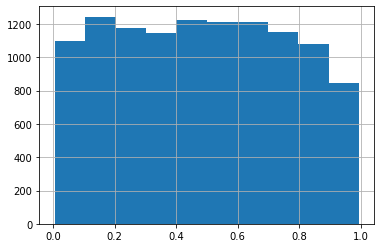

In [65]:
submission_df['Pred'].hist()

In [66]:
submission_df.to_csv('../submissions/Square8.csv', index=False)